$\LaTeX$ macros

# Implementacja "Robust global stabilization and disturbance rejection of an underactuated nonholonomic airship"

Imports

In [1]:
import sympy as sm
import numpy as np
import scipy as sc
import math as m
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp # solving differential equations
MAT = np.array

Definicja wartości stałych współczynniików. Zmieniono wartości kilku współczynników na takie jak autorzy podali w artykule [21]

In [2]:
# constant variables
a_ship = 1.2  # ship length
b_ship = 0.5  # ship width
Cu = 0.42
Cv = 0.42
Cr = 0.42
Vw = 0.1  # wind velocity
#zmieniono progi wartości di, ki, ki_ jak w artykule [21]
d1_ceil = 0.105
d1_floor = 0.027
#d1 = 0.009
d2_ceil = 0.057
d2_floor = 0.029
#d2 = 0.045
d3_ceil = 0.050
d3_floor = 0.035
d3 = 0.042
k1 = 0.32
k2 = 0.29
k3 = 0.13
a = 0.05
k1_ = 0.6#1.6
k2_ = 0.11
k3_ = 0.2
k4_ = 0.11
k5_ = 0.0032
theta_zero = 0.0
r_zero = 0.0
#masa m i m3 przyjęto takie jak autorzy podali w [21]
m12 = 0.072
m3 = 0.018
time = 25
coeff = 1.0

Wzory na współczynniki

In [3]:
K = MAT([[k1_,k2_,k3_,k4_,k5_]])
#wzory (4.1)
k_r = k1 + k2 - d3_floor
k_th = k1*k2
#wzory (4.12)
theta3_floor = a/((k3 - k1)*(k3 - k2))
theta3_ceil = a/(k3**2 - (d3_ceil + k_r)*k3 + k1*k2)
delta_1 = (d1_ceil - d1_floor)*0.5
delta_2 = (d2_ceil - d2_floor)*0.5
delta_3 = (theta3_ceil - theta3_floor)*0.5
Delta_1 = coeff*delta_1
Delta_2 = coeff*delta_2
Delta_3 = coeff*delta_3
d10 = (d1_ceil + d1_floor)*0.5
d20 = (d2_ceil + d2_floor)*0.5
theta30 = (theta3_ceil + theta3_floor)*0.5
#wzory (4.11)
d1 = d10 + Delta_1
d2 = d20 + Delta_2
#theta_3 = theta30 + Delta_3
#wzory (4.3)
Delta_d = d3 - d3_floor
#wzory (4.4)
lambda_1 = 0.5*((Delta_d + k1 + k2) + m.sqrt(Delta_d**2 + 2*Delta_d*(k1 + k2) + (k1 - k2)**2))
lambda_2 = 0.5*((Delta_d + k1 + k2) - m.sqrt(Delta_d**2 + 2*Delta_d*(k1 + k2) + (k1 - k2)**2))
theta_1 = ((lambda_2*theta_zero + r_zero)/(lambda_2 - lambda_1)) + a/((lambda_2 - lambda_1)*(k3 - lambda_1))
theta_2 = ((k1*theta_zero + r_zero)/(lambda_1 - lambda_2)) + a/((lambda_1 - lambda_2)*(k3 - lambda_2))
theta_3 = a/((lambda_1 - k3)*(lambda_2 - k3))

Definicja macierzy o stałych elementach

In [4]:
b = MAT([[1/m12,0,0,0,0]]).T
#macierze (4.14)
A10 = MAT([[-d10,0,0,0,0],[theta30*k3,-(d20 - k3),0,0,0],[1,0,0,0,0],[0,1,theta30*k3,k3,0],[0,0,1,0,0]])
D = MAT([[1,0,0,0],[0,1,1,0],[0,0,0,0],[0,0,0,1],[0,0,0,0]])
E = MAT([[-delta_1,0,0,0,0],[0,-delta_2,0,0,0],[k3*delta_3,0,0,0,0],[0,0,k3*delta_3,0,0]])
DELTA = np.diag([Delta_1/delta_1,Delta_2/delta_2,Delta_3/delta_3,Delta_3/delta_3])

Definicja macierzy o zmiennych wartościach elementów i funkcji

In [5]:
#funkcja r(t) (4.3)
def r(t_):
    return -theta_1*lambda_1*m.exp(-lambda_1*t_) - theta_2*lambda_2*m.exp(-lambda_2*t_) - theta_3*k3*m.exp(-k3*t_)
#funkcja theta(t) (4.3)
def theta(t_):
    return theta_1 *m.exp(-lambda_1*t_) + theta_2*m.exp(-lambda_2*t_) + theta_3*m.exp(-k3*t_)
#funkcja alpha(t) (4.14)
def alpha(t_):
    return -(theta_1*lambda_1*m.exp(-(lambda_1 - k3)*t_) + theta_2*lambda_2*m.exp(-(lambda_2 - k3)*t_))
#macierz A2(t) (4.14)
def A2(t_):
    return MAT([[0,r(t_)*m.exp(-k3*t_),0,0,0],[alpha(t_),0,0,0,0],
                     [0,0,0,r(t_)*m.exp(-k3*t_),0],[0,0,alpha(t_),0,0],[0,0,0,0,0]])
#funkcja obliczającą siłę oporu powietrza uwzględniająca wymiary sterowca
def F(theta_):
    return m.sqrt(a_ship ** 2 * m.sin(theta_) ** 2 + b_ship ** 2 * m.cos(theta_) ** 2)
#macierz (2.6)
def A(r_):
    return MAT([[-d1,r_,0,0],[-r_,-d2,0,0],[1,0,0,r_],[0,1,-r_,0]])
#funkcja obliczającą siłę oporu powietrza czołowego
def fu(theta_):
    return Cu * Vw ** 2 * F(theta_) * m.cos(theta_)
#funkcja obliczającą siłę oporu powietrza bocznego
def fv(theta_):
    return Cv * Vw ** 2 * F(theta_) * m.sin(theta_)
#funkcja obliczającą siłę oporu powietrza przy obrocie sterowca
def fr(theta_):
    return Cr * Vw ** 2 * F(theta_) * m.sin(2 * theta_)
#funkcja obliczającą siłę oporu powietrza (2.6)
def f(theta_):
    return MAT([[fu(theta_)/m12,fv(theta_)/m12,0,0]]).T
#funkcja obliczającą siłę oporu powietrza (4.26)
def f_dis(t_):
    one = Cu*Vw**2*F(theta(t_))*m.cos(theta(t_))/m12
    two = -Cv*Vw**2*m.exp(-k3*t_)*F(theta(t_))*m.sin(theta(t_))/m12
    return MAT([[one,two,0,0,0]]).T
#obbliczenie prędkości sterowca w układzie globalnym (2.4)
def CalcBlimpVel(u_, v_, theta_):
    x_dot_ = u_*np.cos(theta_) - v_*np.sin(theta_)
    y_dot_ = u_*np.sin(theta_) + v_*np.cos(theta_)
    return MAT([[x_dot_, y_dot_]]).T
#(2.5)
def CalcZ1Z2(x_, y_, theta_):
    xc = x_*m.cos(theta_) + y_*m.sin(theta_)
    yc = -x_*m.sin(theta_) - y_*m.cos(theta_)
    return MAT([[xc,yc]]).T
#równanie dynamiki ukłładu (2.6)
def DynamicSystem2(r_, rSter, fr_):
    tmp1 = -d3*r_ + (rSter+fr_)/m3
    tmp2 = r_
    return MAT([[tmp1, tmp2]]).T
#równanie dynamiki układu (2.6) 
def DynamicSystem1(q_, tauu, A, theta_):
    return A@q_+tauu/m12+f(theta_)
#równanie dynamiki układu (4.25)
def DynamicSystem1e(q_, t_):
    return (A10 - b*K + D@DELTA@E + A2(t_))@q_ + f_dis(t_)
#sygnał sterujący tau r
def Controler_r(r_, theta_, t_):
    return m3*(-k_r*r_ - k_th*theta_ + a*m.exp(-k3*t_) - fr(theta_))
#sygnał sterujcy tau u
def Controler_u(u_, v_, z1_, z2_, z3_, t_):
    return -(k1_*u_ + k2_*v_*m.exp(-k3*t_) + k3_*z1_ + k4_*z2_*m.exp(-k3*t_) + k5_*z3_)
#macierz rotacji wokół osi Z układu globalnego
def R(th_):
    return MAT([[np.cos(th_),-np.sin(th_),0],[np.sin(th_),np.cos(th_),0],[0,0,1]])

Funkcja opisująca system dynamiczny

In [6]:
def SystemDyn(t_, xi_array):
    xi = MAT([xi_array]).T
    ui = MAT(xi[0][0])
    vi = MAT(xi[1][0])
    z1i = MAT(xi[2][0])
    z2i = MAT(xi[3][0])
    z3i = MAT(xi[4][0])
    ri = MAT(xi[5][0])
    thetai = MAT(xi[6][0])
    p = MAT([[ui,vi,ri]]).T
    velocity = CalcBlimpVel(ui,vi,thetai)
    q_ = MAT([[ui],[vi],[z1i],[z2i],[z3i]])
    ur = Controler_r(ri, thetai, t_)
    uu = Controler_u(ui,vi,z1i,z2i,z3i,t_)
    dx = DynamicSystem1e(q_,t_)
    acc = DynamicSystem2(ri,ur,fr(thetai))
    pd = R(thetai)@p
    dxi = np.concatenate((dx, acc, velocity, pd))
    return np.ndarray.tolist(dxi.T[0])

Symulacja za pomocą funkcji solve_ivp

In [7]:
xi0_array = [0,0,0,0,0,0,0,0,0,0,0.4,0]#wartości początkowe zmiennych
sim = solve_ivp(SystemDyn, [0, time], xi0_array, method='RK23')
t = sim.t
u, v, z1, z2, z3, rd, ttad, xd, yd, x, y, tta = sim.y # return xi 

Wykresy otrzymanych wielkości w symulacji 

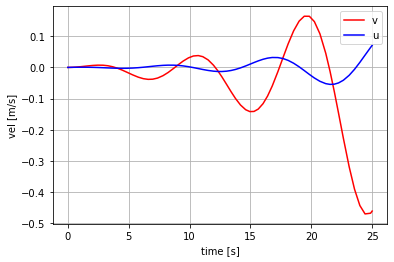

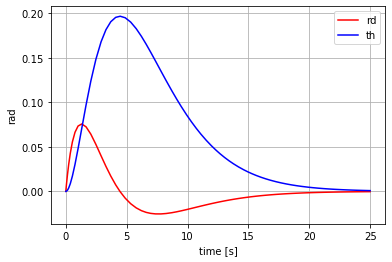

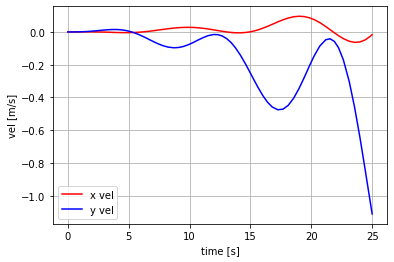

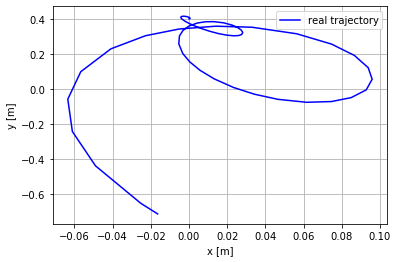

In [8]:
#wykres prędkości w lokalnym układzie sterowca
plt.figure()
plt.plot(t, v, 'r', label='v')
plt.plot(t, u, 'b', label='u')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('vel [m/s]')
plt.grid(True)
plt.show()
#wykres wykres przyśpieszenia kątowego rd i prędkości kąta theta
plt.figure()
plt.plot(t, rd, 'r', label='rd')
plt.plot(t, tta, 'b', label='th')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('rad')
plt.grid(True)
plt.show()
#wykres prędkości w osi x i y układu globalnego 
plt.figure()
plt.plot(t, xd, 'r', label='x vel')
plt.plot(t, yd, 'b', label='y vel')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('vel [m/s]')
plt.grid(True)
plt.show()
#trajektoria poruszania się sterowca
plt.figure()
plt.plot(x,y, 'b', label='real trajectory')
plt.legend(loc='best')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid(True)
plt.show()